In [1]:
# 对/lustre/home/hangqian/data/zircons/Roberts_Spencer_2015.csv的贝叶斯拐点分析
# time bins个数：400
# 拐点个数：3,4,5,6,7,8
# 每核采样数：1000,
# 每核burn数：1000（默认）
# 核数：1

In [10]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

0        2746
1        2542
2        2561
3        2028
4        2096
         ... 
42464    3505
42465    3503
42466    3508
42467    3520
42468    3044
Name: U-Pb (Ma), Length: 42469, dtype: int64
       Reference      Location  176Lu/177Hf  176Hf/177Hf        1_  U-Pb (Ma)  \
0              1        Africa      0.00110     0.280991  0.000027       2746   
1              1        Africa      0.00080     0.280998  0.000021       2542   
2              1        Africa      0.00060     0.281041  0.000020       2561   
3              1        Africa      0.00160     0.281092  0.000038       2028   
4              1        Africa      0.00110     0.281096  0.000027       2096   
...          ...           ...          ...          ...       ...        ...   
42464        166  South Africa      0.00110     0.280510  0.000032       3505   
42465        166  South Africa      0.00110     0.280586  0.000028       3503   
42466        166  South Africa      0.00110     0.280535  0.000041      

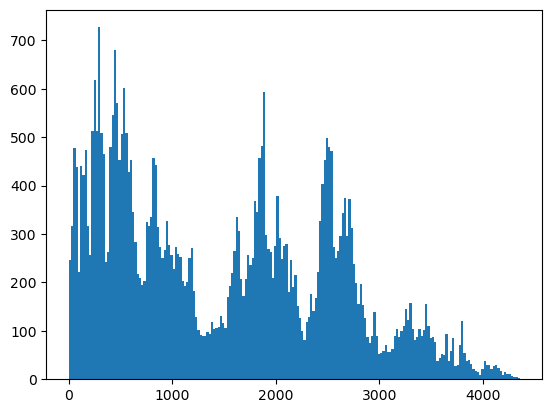

In [11]:
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import poisson
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tools.numdiff import approx_hess1, approx_hess2, approx_hess3
import pandas as pd

df = pd.read_csv('/lustre/home/hangqian/projects/data/zircons/Roberts_Spencer_2015.csv')
years = df["U-Pb (Ma)"]
data = plt.hist(years, bins = 200)
print(years)
print(df)

In [5]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.7.1


In [12]:
zircons_data = data[0]
ages = data[1][1:]
print(len(ages))
print(max(ages))

200
4358.0


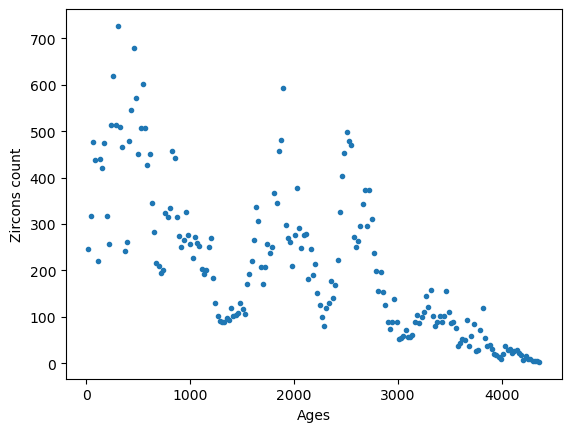

In [13]:
plt.plot(ages, zircons_data, "o", markersize=3, alpha=1)
plt.ylabel("Zircons count")
plt.xlabel("Ages");

In [8]:
tr =pm.distributions.transforms

Order = tr.Ordered()

#Logodd = tr.LogOddsTransform()

#chain_tran = tr.Chain([Logodd, Order])

k = 5

In [9]:
with pm.Model() as model:
    
    k =3
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = max(ages) , shape = k, transform = Order,  initval=np.linspace(0,max(ages),k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr = pm.sample(tune = 1000, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rates, switchpoints]


Sampling 1 chain for 1_000 tune and 196 draw iterations (1_000 + 196 draws total) took 219 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


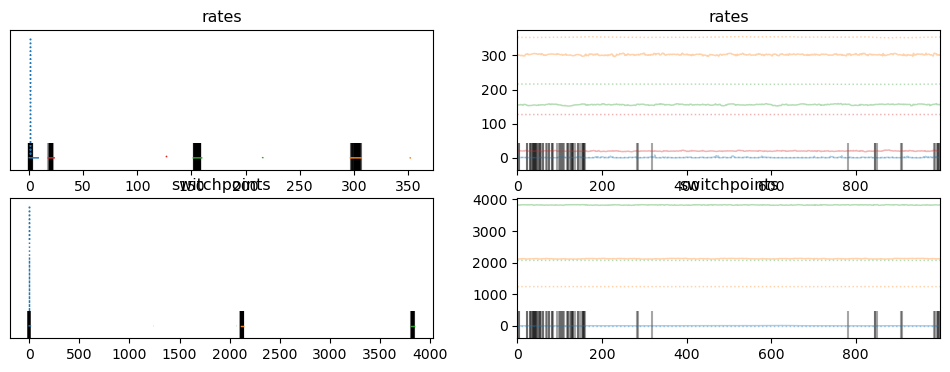

In [9]:
with model:
    az.plot_trace(tr)

In [10]:
pm.summary(tr)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rates[0],0.925,0.692,0.002,2.009,0.041,0.029,158.0,100.0,1.89
rates[1],328.061,25.629,300.449,355.161,18.029,15.246,3.0,26.0,1.88
rates[2],185.850,30.033,154.005,216.527,21.142,17.885,3.0,12.0,2.13
rates[3],73.479,53.486,19.075,127.075,37.667,31.866,3.0,12.0,1.88
switchpoints[0],2.133,2.462,0.046,7.468,1.277,0.985,4.0,23.0,2.34
switchpoints[1],1682.744,441.432,1240.658,2132.487,310.874,262.980,3.0,97.0,1.87
switchpoints[2],2947.904,877.248,2070.059,3833.053,617.815,522.641,3.0,89.0,1.86


In [11]:
with pm.Model() as model:
    
    k =4
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = max(ages) , shape = k, transform = Order,  initval=np.linspace(0,max(ages),k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr = pm.sample(tune = 1000, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'rates_log__': array([ 0.97683667, -0.77490345, -0.41563861,  0.67247861,  0.92988923]), 'switchpoints_ordered__': array([0.40063933, 8.10057384, 7.53195871, 6.88443223])}

Logp initial evaluation results:
{'rates': -6.88, 'switchpoints': -inf, 'counts': -230090.25}
You can call `model.debug()` for more details.

In [ ]:
with model:
    az.plot_trace(tr)
    
pm.summary(tr)

In [12]:
with pm.Model() as model:
    
    k =5
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = max(ages) , shape = k, transform = Order,  initval=np.linspace(100,max(ages)-100,k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr = pm.sample(tune = 1000, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rates, switchpoints]


ValueError: Not enough samples to build a trace.

In [ ]:
with model:
    az.plot_trace(tr)
    
pm.summary(tr)

In [ ]:
with pm.Model() as model:
    
    k =6
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = max(ages) , shape = k, transform = Order,  initval=np.linspace(100,max(ages)-100,k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr = pm.sample(tune = 1000, cores = 1)

In [ ]:
with model:
    az.plot_trace(tr)
    
pm.summary(tr)

In [ ]:
with pm.Model() as model:
    
    k =7
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = max(ages) , shape = k, transform = Order,initval = np.linspace(100,max(ages)-100,k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr = pm.sample(tune = 1000, cores = 1)

In [ ]:
with model:
    az.plot_trace(tr)
    
pm.summary(tr)

In [ ]:
with pm.Model() as model:
    
    k =8
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = max(ages) , shape = k, transform = Order,  initval=np.linspace(100,max(ages)-100,k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr = pm.sample(tune = 1000, cores = 1)

In [ ]:
with model:
    az.plot_trace(tr)
    
pm.summary(tr)

In [ ]:
with pm.Model() as model:
    
    k =8
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = max(ages) , shape = k, transform = Order,  initval=np.linspace(100,max(ages)-100,k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr = pm.sample(draws =5000,tune = 5000, cores = 1)

In [ ]:
with model:
    az.plot_trace(tr)
    
pm.summary(tr)

In [ ]:
with pm.Model() as model:
    
    k =8
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = max(ages) , shape = k, transform = Order,  initval=np.linspace(100,max(ages)-100,k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr = pm.sample(draws =20000,tune = 5000, cores = 1)

In [ ]:
with model:
    az.plot_trace(tr)
    
pm.summary(tr)

In [ ]:
with pm.Model() as model:
    
    k =8
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = max(ages) , shape = k, transform = Order,  initval=np.linspace(100,max(ages)-100,k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr50000 = pm.sample(draws =45000,tune = 5000, cores = 1)

In [ ]:
with model:
    az.plot_trace(tr50000)
    
pm.summary(tr50000)

In [ ]:
with pm.Model() as model:
    
    k =8
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = max(ages) , shape = k, transform = Order,  initval=np.linspace(100,max(ages)-100,k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr100000 = pm.sample(draws =80000,tune = 20000, cores = 1)

In [ ]:
with model:
    az.plot_trace(tr100000)
    
pm.summary(tr100000)

In [ ]:
with pm.Model() as model:
    
    k =8
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = max(ages) , shape = k, transform = Order,  initval=np.linspace(100,max(ages)-100,k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr100000 = pm.sample(draws =80000,tune = 20000, cores = 1)

In [ ]:
with model:
    az.plot_trace(tr100000)
    
pm.summary(tr100000)